# WISESize Master Notebook

### This notebook contains the figures and plots I worked on for the WISESize Project. It is divided up into sections that each tackle a different problem.

In [1]:
# Libraries
import numpy as np
from astropy.table import Table, Column, join
from astropy.coordinates import SkyCoord
from astropy.table import Column
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
from matplotlib.colors import LogNorm
from astropy.utils.data import download_file
import warnings

# Path to the catalog
catalog_path='/Users/EvanB.LAPTOP-8CHCIOMA/Downloads/'

#A100-NSA Catalog
myTab=Table.read(catalog_path+'a100-nsa-for-adap.fits')

## Generating Figures from the Proposal Paper

### Here there cuts being applied to the catalog (myTab). The proposal suggests cuts of SNR > 20, size > 6.5", and redshifts between 0.002 and 0.025.

In [2]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag = W3flag | NUVflag

In [3]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag = (rad_eff1>radmin) | (rad_eff2>radmin)

In [4]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [5]:
# Apply cuts
NSFcut = SNRflag & sizeflag & zflag
cuttab=myTab[NSFcut] # Catalog with all cuts from the proposal applied to it

## RA vs. Dec Plot

13756


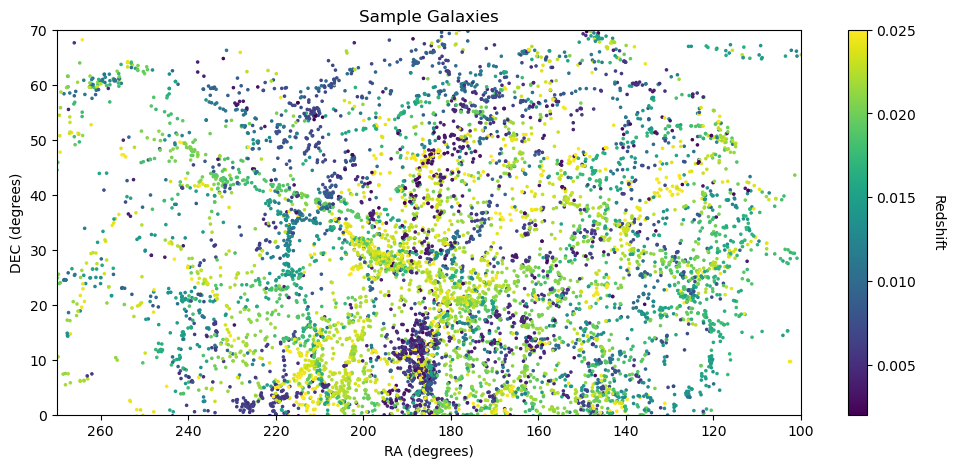

In [6]:
#Define positional and color data
ra = cuttab['RA'] # Right ascension in degrees
dec = cuttab['DEC'] # Declination in degrees
ccode = cuttab['ZDIST'] # Redshift

#Print number of points
print(len(ra))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='viridis',s=2.5) # Plots ra and dec color coded by redshift
plt.xlim(reversed(plt.xlim()))
plt.title('Sample Galaxies')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('Redshift',rotation=270,labelpad=20)
plt.clim(0.002,0.025)

#### This is my recreation of figure 1d from the proposal. It shows the sample that is being proposed. The colors correspond to redshift,

## Resolved Sample Plot

C:\Users\EvanB.LAPTOP-8CHCIOMA\AppData\Local\Temp\ipykernel_9416\2390967751.py:5: RuntimeWarning: divide by zero encountered in log10
  npx = np.array(np.log10(x1))


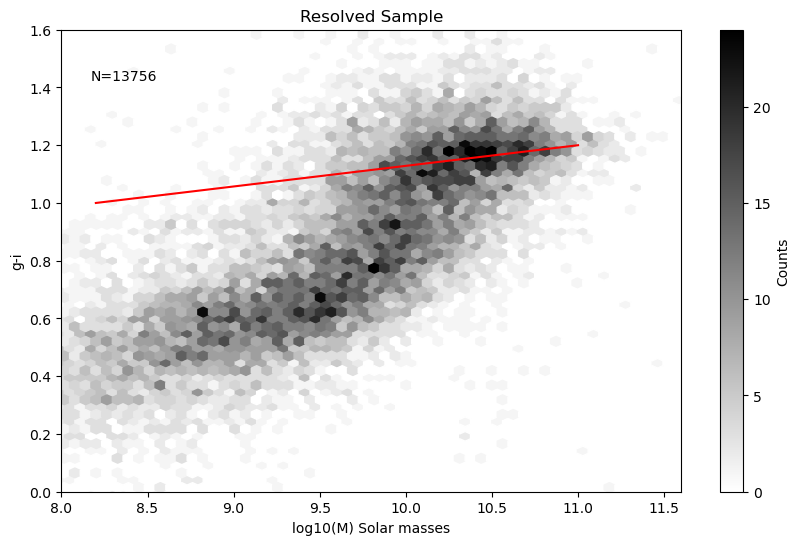

In [7]:
x1 = cuttab['MASS']
y1 = cuttab['ABSMAG'][:,3] - cuttab['ABSMAG'][:,5] #g-i magnitudes, FNUGRIZ- G[:,3] & I[:,5]

#Put x and y into numpy arrays
npx = np.array(np.log10(x1)) 
npy = np.array(y1)

#Figure size
fig,ax = plt.subplots(figsize=(10, 6))

#Hexbin parameters
hb = ax.hexbin(npx,npy,gridsize=[150,850],bins=25,cmap='gray_r')

#Plot hexbin mass vs color diagram
plt.title('Resolved Sample')
ax.set(xlim=(8,11.6),ylim=(0,1.6)) 
fig.colorbar(hb, label='Counts') 
plt.xlabel('log10(M) Solar masses') 
plt.ylabel('g-i')

#Plot Red Sequence line
xx=np.array([8.2 ,11])
yy=np.array([ 1,  1.2])
plt.plot(xx,yy,color='r')
plt.text(0.1,0.9,'N=13756',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### This is figure 2a from the proposal. The red line represents the red sequence. The majority of our sample is made up of blue, star forming galaxies but there is a cluster of AGN and inclined galaxies on the red sequence.

## Comparing Cut Samples

#### I experimented with using different values for the SNR and size cuts and created some plots comparing them.

In [8]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 20
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag20 = W3flag | NUVflag

In [9]:
# Size cut: r-band effective radii greater than two pixels (> 5.500" ) in the unWISE images
radmin = 5.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag55 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [10]:
# SNR cut: GALEX NUV or WISE 12um SNR > 20
snrmin = 10
W3snr = myTab['w3_nanomaggies']
W3snr_ivar = myTab['w3_nanomaggies_ivar']
W3snr = W3snr*np.sqrt(W3snr_ivar)
W3flag = (W3snr>snrmin) | (myTab['W3SNR']>snrmin)  
GALEXsnr = myTab['NMGY'][:,1]
GALEXsnr_ivar = myTab['NMGY_IVAR'][:,1]
GALEXsnr = GALEXsnr*np.sqrt(GALEXsnr_ivar)
NUVflag = GALEXsnr>snrmin
SNRflag10 = W3flag | NUVflag

In [11]:
# Size cut: r-band effective radii greater than two pixels (> 6.500" ) in the unWISE images
radmin = 6.500
rad_eff1 = myTab['SERSIC_TH50']
rad_eff2 = myTab['petroR50_r']
sizeflag65 = (rad_eff1>radmin) | (rad_eff2>radmin)

In [12]:
# Redshift cut: 0.002 < z < 0.025
zmin=0.002
zmax=0.025
redshift = myTab['ZDIST']
vhelio = myTab['Vhelio']
redshiftflag = (redshift>zmin) & (redshift<zmax)
vhelioflag = (vhelio>(zmin*3e5)) & (vhelio<(zmax*3e5))
zflag = redshiftflag | vhelioflag 

In [13]:
# Apply cuts
NSFcut1 = SNRflag20 & sizeflag55 & zflag
cuttab1 = myTab[NSFcut1]

NSFcut2 = SNRflag10 & sizeflag55 & zflag
cuttab2 = myTab[NSFcut2]

NSFcut3 = SNRflag10 & sizeflag65 & zflag
cuttab3 = myTab[NSFcut3]

NSFcut4 = SNRflag20 & sizeflag65 & zflag
cuttab4 = myTab[NSFcut4]

### Redshift Histogram

Text(0.5, 0, 'Redshift')

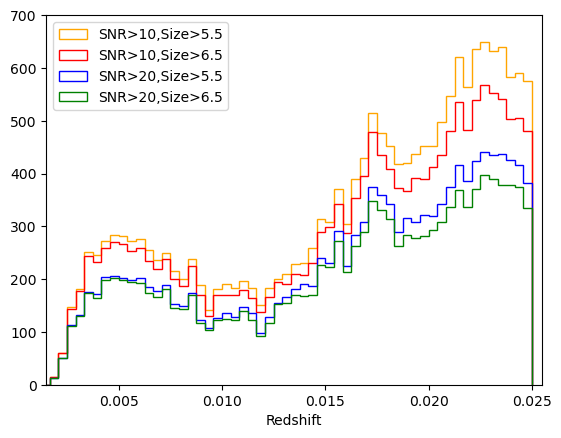

In [14]:
a = cuttab1['ZDIST']#5.5 and 20
b = cuttab2['ZDIST']#5.5 and 10
c = cuttab3['ZDIST']#6.5 and 10
d = cuttab4['ZDIST']#6.5 and 20

plt.hist(b,bins=60,histtype='step',color='orange',fill=False,label='SNR>10,Size>5.5')
plt.hist(c,bins=60,histtype='step',color='red',fill=False,label='SNR>10,Size>6.5')
plt.hist(a,bins=60,histtype='step',color='blue',fill=False,label='SNR>20,Size>5.5')
plt.hist(d,bins=60,histtype='step',color='green',fill=False,label='SNR>20,Size>6.5')
plt.legend()
plt.xlim(0.0015,0.0255)
plt.ylim(0,700)
plt.xlabel('Redshift')

#### This histogram shows the how the number of galaxies is distributed for along redshifts. Its apparent that the green and blue samples are very similar, especially at low redshifts. The red and orange samples are close as well. This suggests changing the size cut does not change the sample size much.

## Cumulative Histogram

#### There are still more ways to test these cuts to see how different they are from each other. There are cumulative histograms and KS tests.

In [15]:
# Function to find luminosities for specified cuts
def W3Lum(cut):
    H0 = 2.3*10**(-18) # /s
    c = 3*10**8 # m/s
    z = cut['ZDIST']

    v = z*c # Finds velocity from redshift
    d = v/H0 # Finds distance from velocities
    
    w3nmgy = cut['w3_nanomaggies'] # nanomaggies
    w3Jy = w3nmgy*(3.631*10**(-6)) # Converts nanomaggies to Janskys
    w3Flux = w3Jy*10**(-26) # Converts Janskys to W/m^2/Hz
    
    #Flux of Sun
    Msunab = 8.48 # Magnitude of Sun in AB magnitudes
    Fsun = 3631*10**(Msunab/-2.5) # Jy
    Fsun2 = Fsun*10**(-26) # W/m^2/Hz
    r = 10*3*10**17 # m This is a distance of 10 parsecs (AB magnitudes)
    Lsun = Fsun2*(4*np.pi*r**2) # Luminosity of Sun
    
    Lw3 = w3Flux*(4*np.pi*d**2)/Lsun # W1 Luminosity in solar luminosities
    return Lw3

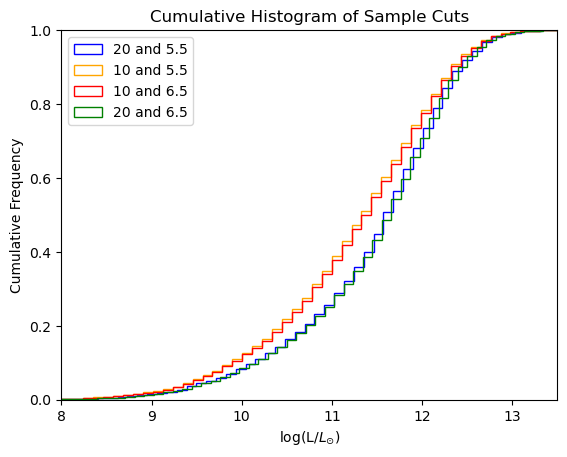

In [16]:
# Cumulative Histograms for W3 Luminosity
fig, ax = plt.subplots()

# Plotting the different cuts
plt.hist(np.log10(W3Lum(cuttab1)),bins=60,histtype='step',fill=False,color='blue',cumulative=True,density=True,label='20 and 5.5')
plt.hist(np.log10(W3Lum(cuttab2)),bins=60,histtype='step',fill=False,color='orange',cumulative=True,density=True,label='10 and 5.5')
plt.hist(np.log10(W3Lum(cuttab3)),bins=60,histtype='step',fill=False,color='red',cumulative=True,density=True,label='10 and 6.5')
plt.hist(np.log10(W3Lum(cuttab4)),bins=60,histtype='step',fill=False,color='green',cumulative=True,density=True,label='20 and 6.5')

# Plot Formatting
plt.title('Cumulative Histogram of Sample Cuts')
plt.xlabel('log(L/$L_{\odot}$)')
plt.ylabel('Cumulative Frequency')
plt.xlim(8,13.5)
plt.ylim(0,1)
plt.legend()

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### From this plot it appears that the snr=10 cuts have a median at slightly lower luminosities than the snr=20 cuts which is to be expected since the lower snr cuts should have a higher number of less luminous galaxies in them. It also appears that the cuts with different sizes cannot be distinguished but we can use a KS Test to test this.

In [17]:
# KS Test
import scipy

# KS Test (This takes two arrays / datasets as inputs and computes various statistics like p-values)
kssnr_20 = scipy.stats.kstest(np.log10(W3Lum(cuttab1)),np.log10(W3Lum(cuttab4))) #SNR=20, 5.5<size<6.5
kssnr_10 = scipy.stats.kstest(np.log10(W3Lum(cuttab2)),np.log10(W3Lum(cuttab3))) #SNR=10, 5.5<size<6.5

print(kssnr_20)
print(kssnr_10)

KstestResult(statistic=0.010389825807507939, pvalue=0.9626619734029543, statistic_location=11.875396001299343, statistic_sign=1)
KstestResult(statistic=0.011854896823420029, pvalue=0.8036257951648608, statistic_location=11.526889725843755, statistic_sign=1)


#### Generally a p-value > 0.05 is considered too large for the data to be sufficiently distinguishable and here the p-values are very high. This means that you can not rule out that the size cuts are from the same distribution. 

## Luminosity vs. Redshift Plots

#### These plots are mostly used to check that the characteristics that we are using for our cuts behave as expected.

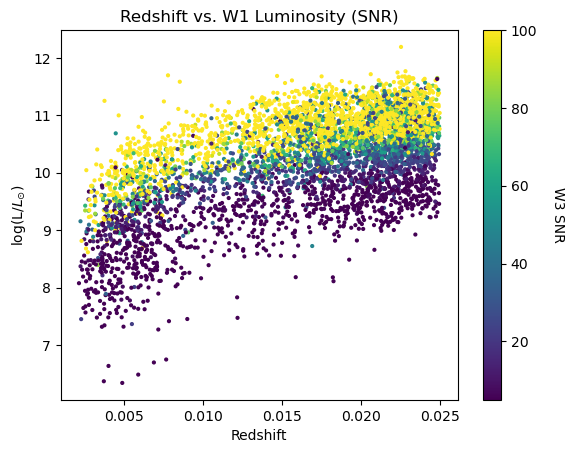

In [18]:
#Plot W3 luminosity vs redshift colored by SNR

# Function to find W1 luminosities for specfic cut
def W1Lum(cut):
    H0 = 2.3*10**(-18) # /s
    c = 3*10**8 # m/s
    z = cut['ZDIST'] # Redshifts

    v = z*c # Finds velocity from redshift
    d = v/H0 # Finds distance from velocities
    
    w1nmgy = cut['w1_nanomaggies'] # nanomaggies
    w1Jy = w1nmgy*(3.631*10**(-6)) # Converts nanomaggies to Janskys
    w1Flux = w1Jy*10**(-26) # Converts Janskys to W/m^2/Hz
    
    #Flux of Sun
    Msunab = 8.48 # Magnitude of Sun in AB magnitudes
    Fsun = 3631*10**(Msunab/-2.5) # Jy
    Fsun2 = Fsun*10**(-26) # W/m^2/Hz
    r = 10*3*10**17 # m This is a distance of 10 parsecs (AB magnitudes)
    Lsun = Fsun2*(4*np.pi*r**2) # Luminosity of Sun
    
    Lw1 = w1Flux*(4*np.pi*d**2)/Lsun # W1 Luminosity in solar luminosities
    return Lw1

# Combining some of the W3 columns to get W3 SNR
W3snr = cuttab['w3_nanomaggies']
W3snr_ivar = cuttab['w3_nanomaggies_ivar']
W3snr_cut = W3snr*np.sqrt(W3snr_ivar)
ccode = W3snr_cut

# Redshift from the original SNR>20 and size>6.5" cut
cutz = cuttab['ZDIST']

# Plot
plt.scatter(cutz,np.log10(W1Lum(cuttab)),s=4,c=ccode,cmap='viridis',clim=(5,100))
plt.title('Redshift vs. W1 Luminosity (SNR)')
plt.ylabel('log(L/$L_{\odot}$)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('W3 SNR',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

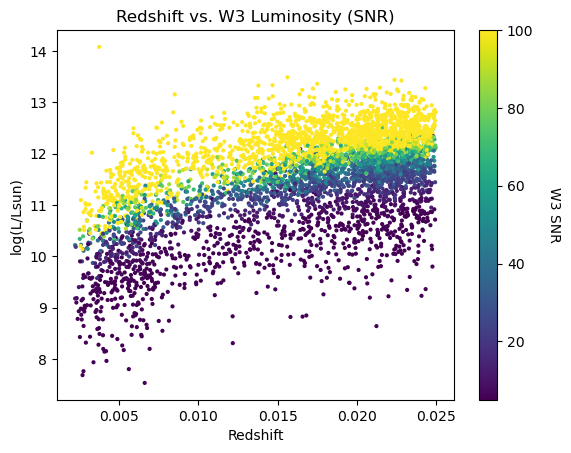

In [19]:
#Plot W3 luminosity vs redshift colored by SNR

plt.scatter(cutz,np.log10(W3Lum(cuttab)),s=4,c=ccode,cmap='viridis',clim=(5,100))
plt.title('Redshift vs. W3 Luminosity (SNR)')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('W3 SNR',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### Both of these plots behave as expected. SNR should increase as luminosity increases. There is also a slight curve due to the effects of redshift. 

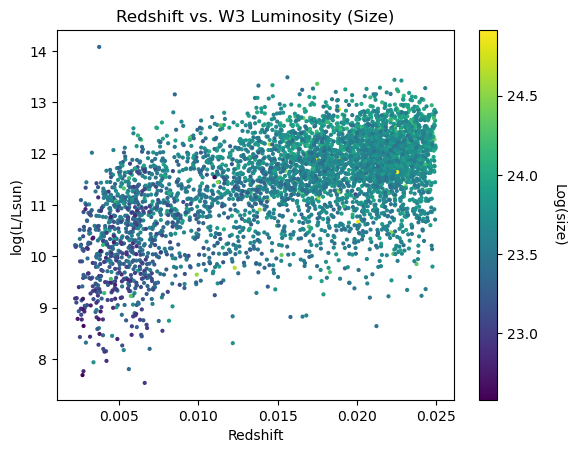

In [20]:
#Plot W3 luminosity vs redshift colored by size
degrees = cuttab['SERSIC_TH50'] # Angular size in degrees
radians = degrees*(np.pi/180) # Angular size in radians

H0 = 2.3*10**(-18) # /s
c = 3*10**8 # m/s
W3z = cuttab['ZDIST'] # Redshifts

v = W3z*c # Finds velocity from redshift
d = v/H0 

# Small angle approximation
size = d * radians # Distance in m
ccode = np.log10(size)



plt.scatter(cutz,np.log10(W3Lum(cuttab)),s=4,c=ccode,cmap='viridis')
plt.title('Redshift vs. W3 Luminosity (Size)')
plt.ylabel('log(L/Lsun)')
plt.xlabel('Redshift')
cbar = plt.colorbar()
cbar.set_label('Log(size)',rotation=270,labelpad=20)

warnings.filterwarnings('ignore',category=RuntimeWarning)

#### The size of galaxies also changes with redshift as we would expect. We see more small galaxies nearby and generally see more large galaxies farther out since the smaller ones will be harder to detect, especially with the limits on SNR we are using.

## Local Density

#### Here I had to calculate the fifth nearest neighbor of each galaxy and use that to find their local density. I defined a function below to do that and then used that function to make plots at three different redshift slices to check that my function worked correctly.

In [21]:
# This function finds the fifth nearest galaxies to each galaxy and returns a density of fifth nearest neighbors
def Local_Density(cuttab):
    ra = np.array(cuttab['RA']) # Right ascension of each galaxy
    dec = np.array(cuttab['DEC']) # Declination of each galaxy

    points = []
    for i in range(len(dec)):
        points.append((ra[i],dec[i])) # Array of tuples of ra and dec (each galaxy now represented by a point)

    def distance(ra1, dec1, ra2, dec2):
        return ((ra1 - ra2) ** 2 + (dec1 - dec2) ** 2) ** ( 1 / 2) # Distance between two points    

    def Five_Nearest(points, target, K):
        pts = []
        n = len(points)
        d = []
 
        for i in range(n):
            d.append({
                "first": distance(points[i][0], points[i][1], target[0], target[1]), # Finds distance between target point and another point
                "second": i # Stores new point that had its distance relative to the target found
            })
     
        d = sorted(d, key=lambda l:l["first"]) # Sorts d from smallest to largest distance for each target point
 
        for i in range(K): # Loops through for however many times are specified by K (I will use K=6)
            pt = []
            pt.append(points[d[i]["second"]][0]) # First element of a tuple in an array of nearest points sorted by distance
            pt.append(points[d[i]["second"]][1]) # Second element of a tuple in an array of nearest points sorted by distance
            pts.append(pt) # Stores all individual pt values as tuples
 
        return pts # Returns the six nearest galaxies to a target galaxy (the first of which is the original target galaxy)


    # Find five nearest galaxies to each galaxy

    five_nn = [] # Store nearest neighbors
    K = 6 # Number of times to calaculate nearest neighbors

    for i in range(len(points)):
        target = points[i] # Switches target point
        for pt in Five_Nearest(points, target, K): # Calculates five nearest points for each points in points and stores them along with their targets
            five_nn.append((pt[0], pt[1])) # Includes six points for each target, the first of which in each set is the target itself
        

    # Separating target points from fifth nearest points

    target_fnn = points #five_nn[0::6] # list of original target galaxies
    fifth_nearest_neighbors = five_nn[5::6] # fifth nearest point of each target


    # Finding angular distance

    dist_fifthnn = []

    # Calculates distance between each galaxy and its fifth nearest meighbor

    for i in range(len(fifth_nearest_neighbors)):
        target0 = target_fnn[i] # Changes target on each loop through
        dist_fifthnn.append(distance(fifth_nearest_neighbors[i][0], fifth_nearest_neighbors[i][1], target0[0], target0[1])) # Produces distance array
 
    angle = np.array(dist_fifthnn)


    # Redshifts of fifth nearest neighbors

    # This compares each point in fifth nearest neighbors to each point in points and stores their respective z values
    z_fnn = []
    for i in range(len(fifth_nearest_neighbors)):
        for j in range(len(points)): 
            if fifth_nearest_neighbors[i][0] == points[j][0]:
                z_fnn.append(cuttab['ZDIST'][j]) 
            
            
    # Converting angular distances to kpc

    # Array of redshifts for each fifth nearest neighbor
    z = np.array(z_fnn)

    # Convert angles in degrees to radians
    radians = (np.pi/180)*(angle)

    # Finding distance, in m, between the Sun and the galaxies
    H0 = 2.3*10**(-18) #/s
    c = 3*10**8 #m/s

    v = z*c 
    d = v/H0 #m

    # Using small angle approximation to convert to kpc
    r_5 = (d*radians)*(3*10**(-19)) #kpc


    # Find fifth nearest neighbor density
    sigma_5 = 1/(r_5**2)
    
    return sigma_5

In [32]:
# R-band Magnitude Limit
Mrmax = -18.2
Mr = myTab['ABSMAG'][:,4] # R-band magnitude from catalog
Mrflag = Mr < Mrmax # Cuts r-band magnitudes greater than the max r-band magnitude limit

# Velocity input
vinput = int(input()) # Asks for a velocity to create a new cut based off of
v = myTab['Vhelio'] # Recessional velocity from catalog
vflag = (v > -1*vinput) & (v < vinput) # Applies a cut (+/- the input velocity) to the data set 

# I used a velocity of 1500 km/s to make my plots

# Redshift cut
zdist = myTab['ZDIST']
zflag = (zdist > 0.002) & (zdist < 0.014)


cut = Mrflag & vflag & zflag # Combines both cuts

cuttab_1 = myTab[cut]

 1500


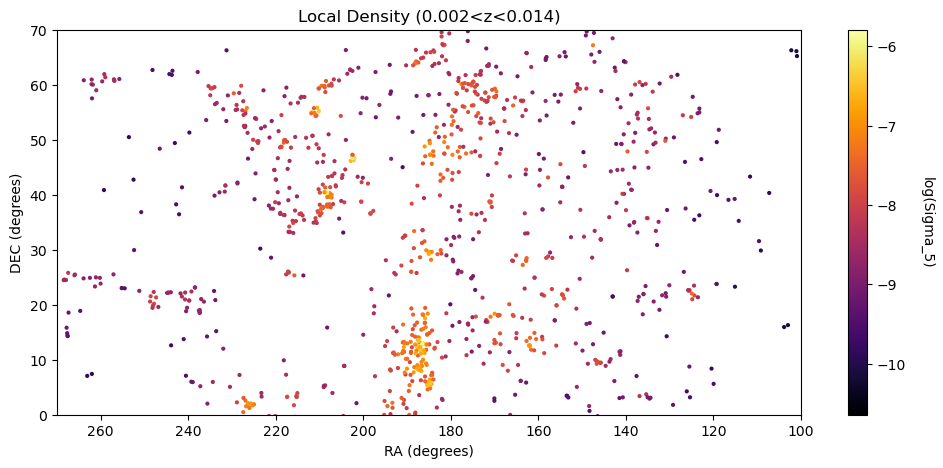

In [34]:
# Plot with range of 0.002<z<0.012
ra = cuttab_1['RA']
dec = cuttab_1['DEC']
ccode = np.log10(Local_Density(cuttab_1))

#Plot RA vs DEC and color it by local density
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.002<z<0.014)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)

In [35]:
# Redshift cut
zdist2 = myTab['ZDIST']
zflag2 = (zdist2 > 0.014) & (zdist2 < 0.020)


cut2 = Mrflag & vflag & zflag2 # Combines both cuts

cuttab_2 = myTab[cut2]

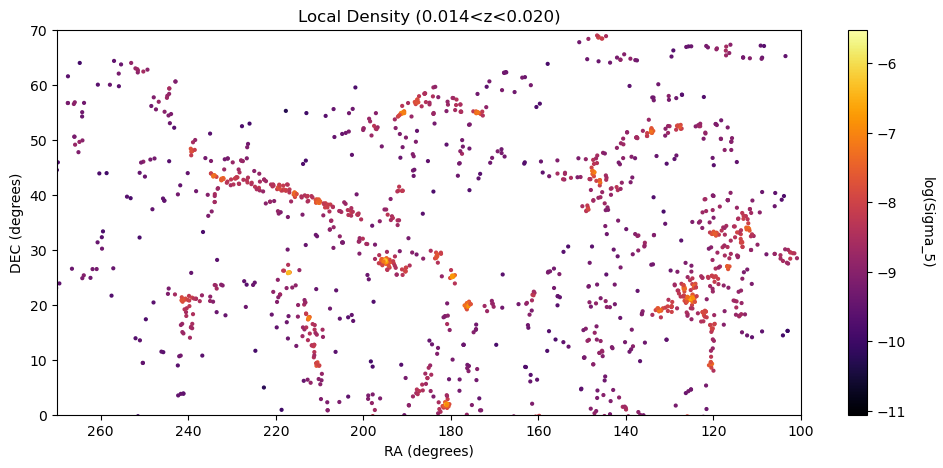

In [36]:
# Plot with range of 0.014<z<0.020
ra = cuttab_2['RA']
dec = cuttab_2['DEC']
ccode = np.log10(Local_Density(cuttab_2))

#Plot RA vs DEC and color it by local density
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4)
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.014<z<0.020)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)

In [37]:
# Redshift cut
zdist3 = myTab['ZDIST']
zflag3 = (zdist3 > 0.020) & (zdist3 < 0.025)


cut3 = Mrflag & vflag & zflag3 # Combines both cuts

cuttab_3 = myTab[cut3]

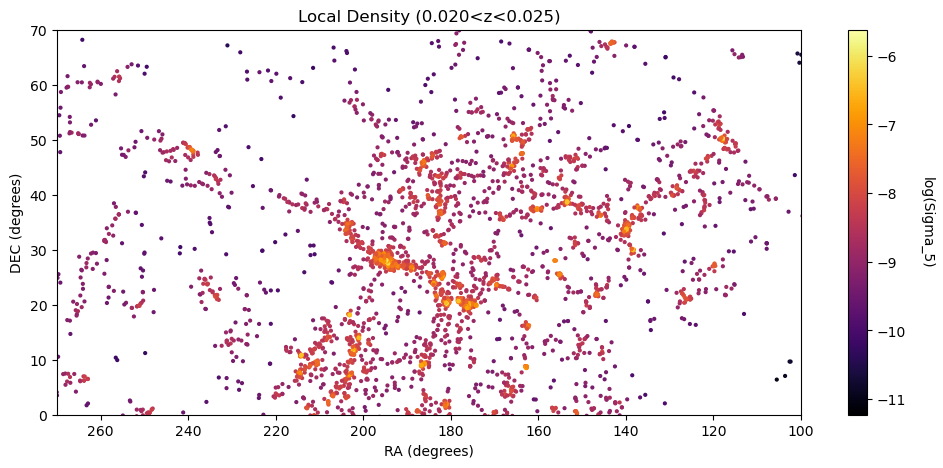

In [39]:
# Plot with range of 0.020<z<0.025
ra = cuttab_3['RA']
dec = cuttab_3['DEC']
ccode = np.log10(Local_Density(cuttab_3))

#Plot RA vs DEC and color it by recessional velocity
plt.figure(figsize=(12,5))
plt.scatter(ra,dec,c=ccode,cmap='inferno',s=4) # ,alpha=0.8
plt.xlim(reversed(plt.xlim()))
plt.title('Local Density (0.020<z<0.025)')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.xlim(270,100)
plt.ylim(0,70)
cbar = plt.colorbar()
cbar.set_label('log(Sigma_5)',rotation=270,labelpad=20)

#### These plots look how I would expect, so my function worked correctly. The areas with a higher density of points have brighter colors and the less dense areas have darker colors. There also appears to be more dense areas and structures at higher redshifts.